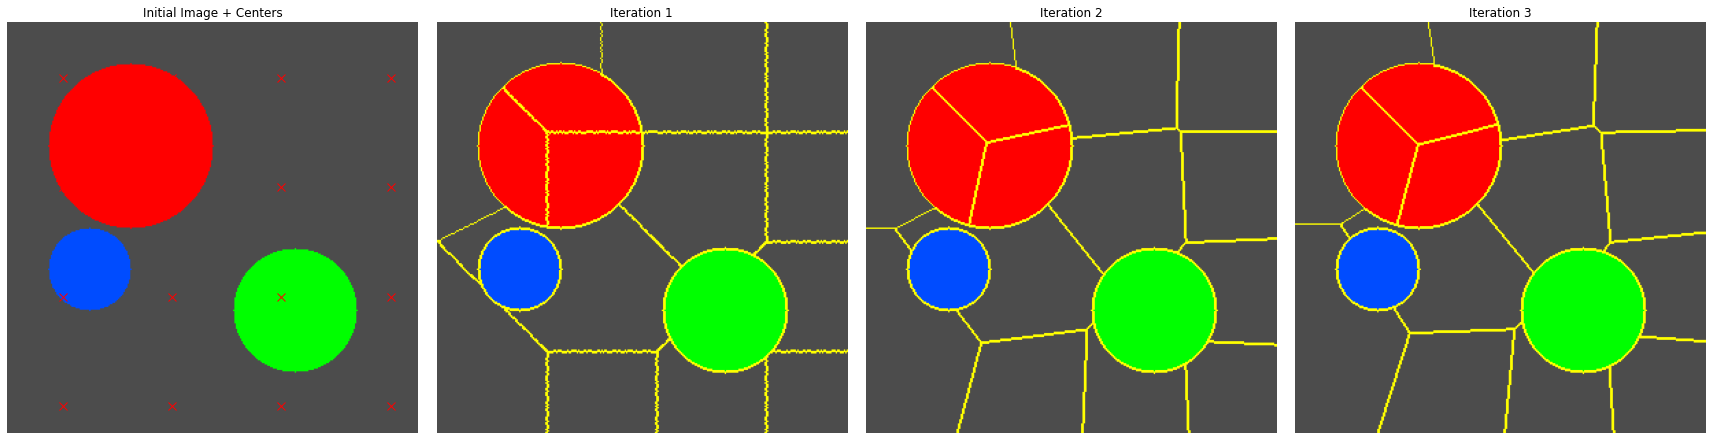

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries

def create_synthetic_image(height=300, width=300):
    """
    Create a synthetic image with simple circular regions in color, 
    at a higher resolution than the previous 100x100 default.
    """
    # Start with a gray background
    image = np.ones((height, width, 3), dtype=float) * 0.3
    
    # Coordinate arrays
    rr, cc = np.ogrid[:height, :width]
    
    # Red circle
    mask_red = (rr - 90)**2 + (cc - 90)**2 <= 60**2
    image[mask_red] = [1.0, 0.0, 0.0]  # bright red

    # Green circle
    mask_green = (rr - 210)**2 + (cc - 210)**2 <= 45**2
    image[mask_green] = [0.0, 1.0, 0.0]  # bright green
    
    # Blue circle
    mask_blue = (rr - 180)**2 + (cc - 60)**2 <= 30**2
    image[mask_blue] = [0.0, 0.3, 1.0]  # lighter blue
    
    return img_as_float(image)

def initialize_cluster_centers(img_lab, grid_step):
    """
    Place initial SLIC cluster centers in a grid pattern. 
    Each center has [L, A, B, y, x].
    """
    rows, cols, _ = img_lab.shape
    centers = []
    for y in range(grid_step // 2, rows, grid_step):
        for x in range(grid_step // 2, cols, grid_step):
            L, A, B = img_lab[y, x]
            centers.append([L, A, B, y, x])
    return np.array(centers, dtype=np.float32)

def compute_distances_and_assign(img_lab, centers, S, m):
    """
    Assign each pixel to the nearest cluster center within a limited search window.
    Returns distance map and label map.
    """
    rows, cols, _ = img_lab.shape
    distances = np.full((rows, cols), np.inf, dtype=np.float32)
    labels = np.full((rows, cols), -1, dtype=np.int32)
    
    region = 2 * S  # search window size
    
    for idx, c in enumerate(centers):
        Lc, Ac, Bc, yc, xc = c
        y_min = max(int(yc - region), 0)
        y_max = min(int(yc + region), rows)
        x_min = max(int(xc - region), 0)
        x_max = min(int(xc + region), cols)
        
        # Extract local patch
        patch = img_lab[y_min:y_max, x_min:x_max]
        
        # Color distance
        L_diff = patch[..., 0] - Lc
        A_diff = patch[..., 1] - Ac
        B_diff = patch[..., 2] - Bc
        color_dist = np.sqrt(L_diff**2 + A_diff**2 + B_diff**2)
        
        # Spatial distance
        yy, xx = np.mgrid[y_min:y_max, x_min:x_max]
        spatial_dist = np.sqrt((yy - yc)**2 + (xx - xc)**2)
        
        # Combined distance
        D = color_dist + (m / S) * spatial_dist
        
        # Update where this center is closer
        closer = D < distances[y_min:y_max, x_min:x_max]
        distances[y_min:y_max, x_min:x_max][closer] = D[closer]
        labels[y_min:y_max, x_min:x_max][closer] = idx
    
    return distances, labels

def update_centers(img_lab, labels, k):
    """
    Update each cluster center as the mean [L, A, B, y, x] of pixels in that cluster.
    """
    new_centers = []
    for i in range(k):
        ys, xs = np.where(labels == i)
        if len(ys) == 0:
            # If no pixels belong to this cluster, keep old center or skip
            new_centers.append([0,0,0,0,0])
            continue
        
        # Mean Lab
        L_mean = np.mean(img_lab[ys, xs, 0])
        A_mean = np.mean(img_lab[ys, xs, 1])
        B_mean = np.mean(img_lab[ys, xs, 2])
        # Mean spatial
        y_mean = np.mean(ys)
        x_mean = np.mean(xs)
        
        new_centers.append([L_mean, A_mean, B_mean, y_mean, x_mean])
    
    return np.array(new_centers, dtype=np.float32)

def slic_iteration_demo(image, S=30, m=10, max_iter=3):
    """
    Run a simplified SLIC on the given image for 'max_iter' iterations,
    and plot intermediate results to illustrate how centers/labels evolve.
    """
    # Convert to Lab for more uniform color distance
    img_lab = color.rgb2lab(image)
    
    # 1) Initialize
    centers = initialize_cluster_centers(img_lab, S)
    
    # Create subplots for each iteration + initial state
    fig, axes = plt.subplots(1, max_iter + 1, figsize=(6*(max_iter+1), 6))
    axes = axes.ravel()
    
    # Plot (a): Input image with initial seeds
    axes[0].imshow(image)
    axes[0].set_title("Initial Image + Centers")
    for c in centers:
        # Mark cluster centers with 'x'
        axes[0].plot(c[4], c[3], 'x', color='red', markersize=8)
    axes[0].axis('off')
    
    labels = None
    
    # 2) Iterations
    for i in range(max_iter):
        # Assign pixels to the nearest center
        _, labels = compute_distances_and_assign(img_lab, centers, S, m)
        
        # Update centers
        centers = update_centers(img_lab, labels, len(centers))
        
        # Plot the label boundaries
        iteration_str = f"Iteration {i+1}"
        axes[i+1].imshow(mark_boundaries(image, labels))
        axes[i+1].set_title(iteration_str)
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return labels


synthetic_img = create_synthetic_image(height=300, width=300)

# Run the SLIC iteration visualization with larger superpixel size S=30
final_labels = slic_iteration_demo(synthetic_img, S=80, m=10, max_iter=3)


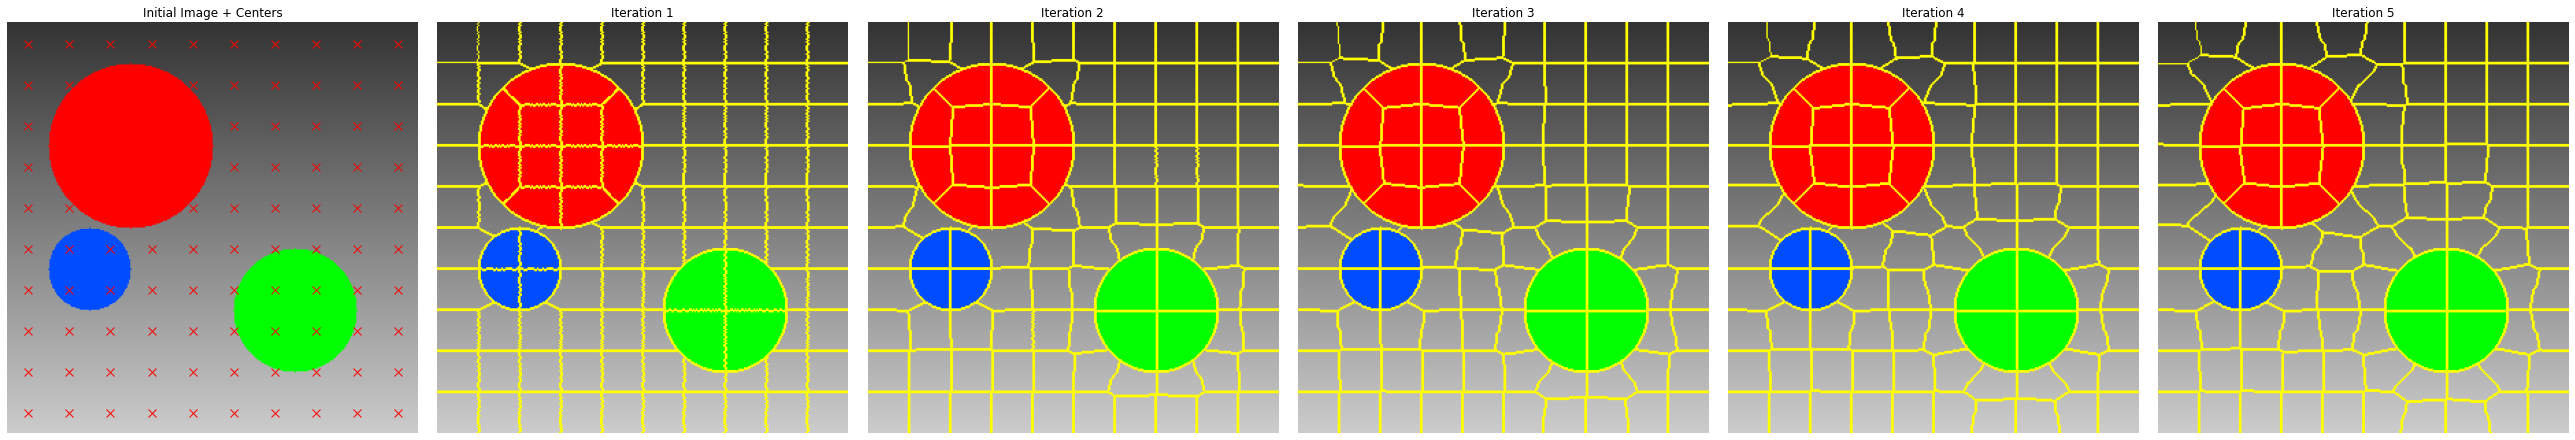

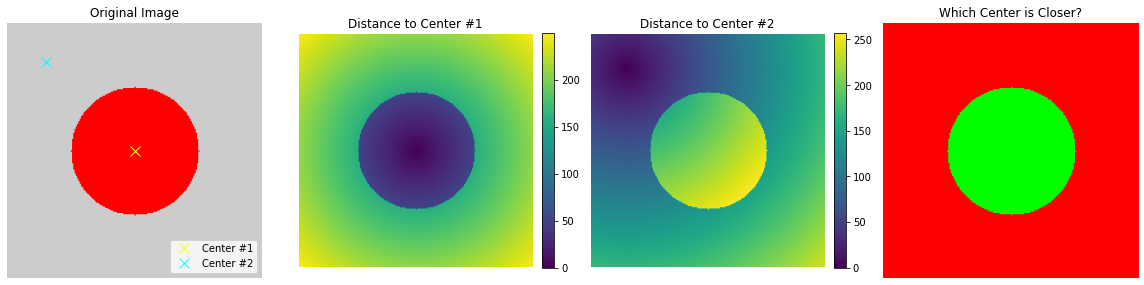

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage.util import img_as_float

def create_circle_image(height=200, width=200, radius=50):
    """
    Create a simple synthetic image with:
      - A solid red circle in the center
      - A uniform light-gray background
    """
    # Initialize the entire image to light gray (e.g. [0.8, 0.8, 0.8])
    image = np.full((height, width, 3), fill_value=0.8, dtype=float)
    
    # Coordinates
    yy, xx = np.mgrid[:height, :width]
    center_y, center_x = height // 2, width // 2
    
    # Define a red circle
    circle_mask = (yy - center_y)**2 + (xx - center_x)**2 <= radius**2
    image[circle_mask] = [1.0, 0.0, 0.0]  # pure red
    
    return img_as_float(image)

def compute_slic_distance(pixel_lab, pixel_xy, center_lab, center_xy, S=1, m=1):
    """
    Compute SLIC-like distance between a pixel and a cluster center.
    
    D = sqrt( (L_p - L_c)^2 + (A_p - A_c)^2 + (B_p - B_c)^2 ) 
        + (m / S) * sqrt( (x_p - x_c)^2 + (y_p - y_c)^2 )
    
    - pixel_lab: (L_p, A_p, B_p)
    - pixel_xy:  (y_p, x_p)
    - center_lab: (L_c, A_c, B_c)
    - center_xy:  (y_c, x_c)
    - S, m: parameters controlling spatial vs color weighting
    """
    # Color distance (Euclidean in Lab)
    d_color = np.sqrt(np.sum((pixel_lab - center_lab)**2))
    # Spatial distance (Euclidean in XY)
    dy = pixel_xy[0] - center_xy[0]
    dx = pixel_xy[1] - center_xy[1]
    d_spatial = np.sqrt(dy**2 + dx**2)
    
    return d_color + (m / S) * d_spatial

def demo_two_clusters():
    """
    1) Create a 200x200 image with a red circle in the center
    2) Manually define two cluster centers:
       - Center #1 at the red circle center
       - Center #2 in the background corner
    3) Compute and visualize the SLIC distance to each center
       and the final assignment (which is closer).
    """
    # Create image (red circle on light-gray)
    img_rgb = create_circle_image(height=200, width=200, radius=50)
    # Convert to Lab for more uniform color distance
    img_lab = color.rgb2lab(img_rgb)
    
    # Manually specify two cluster centers:
    #  -- c1: near the center of the image (inside the red circle)
    #  -- c2: near the top-left corner (background)
    center1_xy = (img_lab.shape[0] // 2, img_lab.shape[1] // 2)  # (y, x)
    center2_xy = (30, 30)  # top-left corner region

    # Extract their Lab values from the image
    center1_lab = img_lab[center1_xy[0], center1_xy[1]]  # (L, A, B)
    center2_lab = img_lab[center2_xy[0], center2_xy[1]]
    
    # For demonstration, pick S=1, m=1 for simplicity
    S = 1
    m = 1
    
    # Create distance maps
    height, width, _ = img_lab.shape
    dist1_map = np.zeros((height, width), dtype=float)  # distance to center1
    dist2_map = np.zeros((height, width), dtype=float)  # distance to center2
    
    # Compute pixel-wise distances
    for y in range(height):
        for x in range(width):
            pixel_lab = img_lab[y, x]
            pixel_xy = (y, x)
            dist1_map[y, x] = compute_slic_distance(pixel_lab, pixel_xy,
                                                    center1_lab, center1_xy, S, m)
            dist2_map[y, x] = compute_slic_distance(pixel_lab, pixel_xy,
                                                    center2_lab, center2_xy, S, m)
    
    # Assign each pixel to whichever center is closer
    labels = (dist1_map <= dist2_map).astype(int)
    # labels[y,x] = 0 means center1 is closer, 1 means center2 is closer
    
    # Visualization
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    
    # (1) Original image
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Plot the positions of the centers
    axes[0].plot(center1_xy[1], center1_xy[0], 'x', color='yellow', markersize=10, label='Center #1')
    axes[0].plot(center2_xy[1], center2_xy[0], 'x', color='cyan', markersize=10, label='Center #2')
    axes[0].legend(loc="lower right")
    
    # (2) Distance to center #1
    im2 = axes[1].imshow(dist1_map, cmap='viridis')
    axes[1].set_title("Distance to Center #1")
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    # (3) Distance to center #2
    im3 = axes[2].imshow(dist2_map, cmap='viridis')
    axes[2].set_title("Distance to Center #2")
    axes[2].axis('off')
    fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    
    # (4) Final assignment map
    # For simplicity, color label=0 as red, label=1 as green
    assignment_img = np.zeros((height, width, 3), dtype=float)
    assignment_img[labels==0] = [1, 0, 0]   # red
    assignment_img[labels==1] = [0, 1, 0]   # green
    axes[3].imshow(assignment_img)
    axes[3].set_title("Which Center is Closer?")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()


demo_two_clusters()


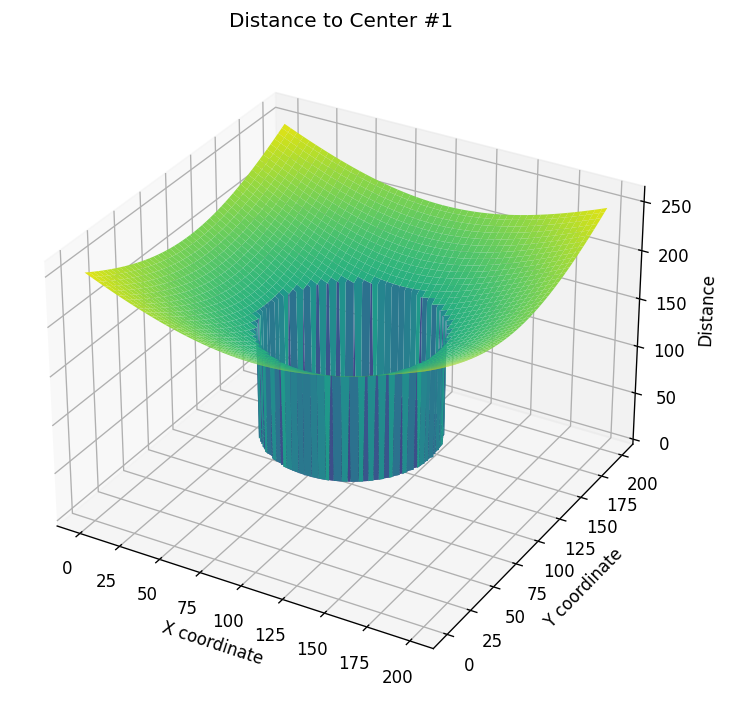

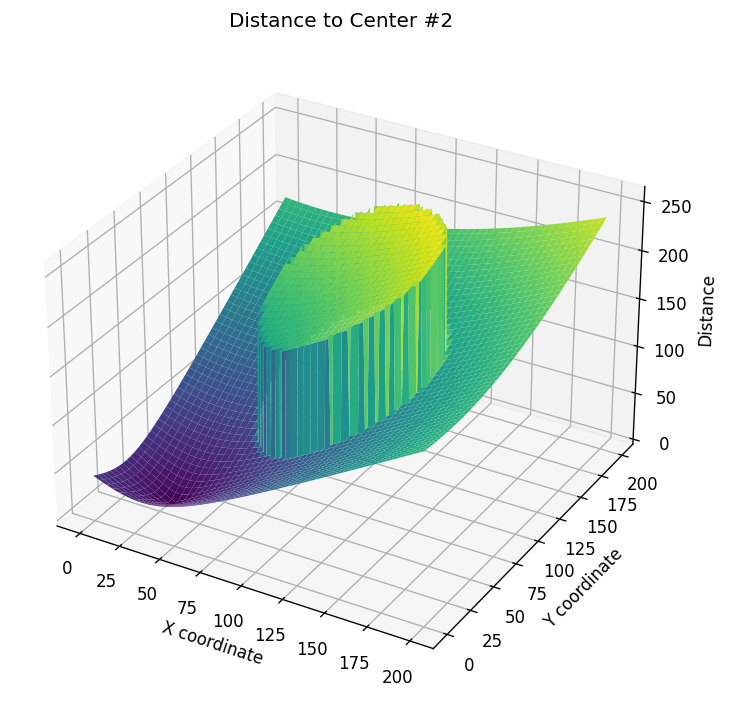

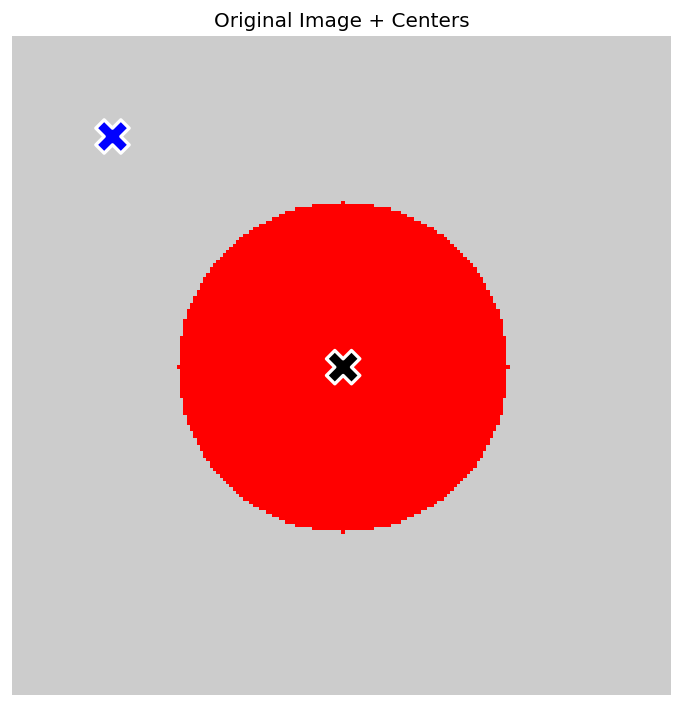

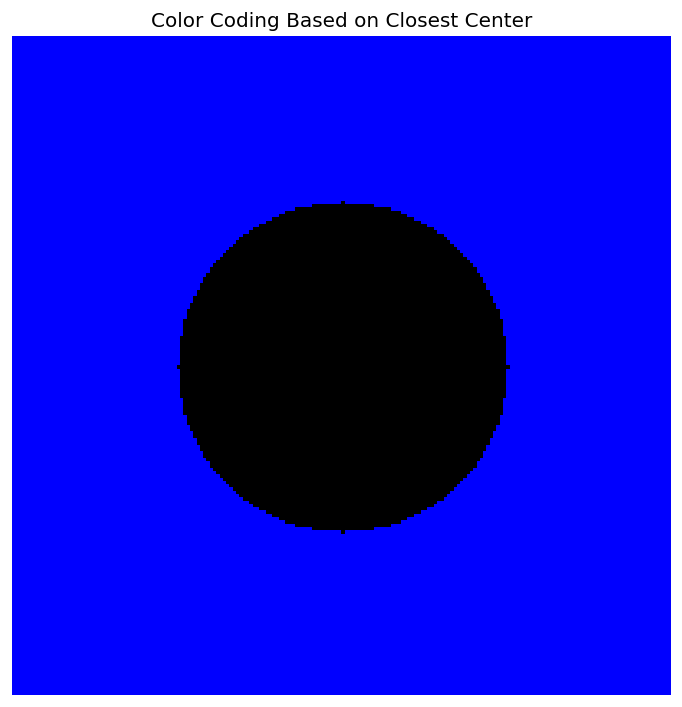

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import color
from skimage.util import img_as_float

def create_circle_image(height=200, width=200, radius=50):
    """
    Create a simple synthetic image with:
      - A solid red circle in the center
      - A uniform light-gray background
    """
    image = np.full((height, width, 3), fill_value=0.8, dtype=float)
    yy, xx = np.mgrid[:height, :width]
    center_y, center_x = height // 2, width // 2
    circle_mask = (yy - center_y)**2 + (xx - center_x)**2 <= radius**2
    image[circle_mask] = [1.0, 0.0, 0.0]  # pure red
    return img_as_float(image)

def slic_distance(pixel_lab, pixel_xy, center_lab, center_xy, S=1, m=1):
    """
    D = sqrt((Lp - Lc)^2 + (Ap - Ac)^2 + (Bp - Bc)^2)
      + (m / S)*sqrt((xp - xc)^2 + (yp - yc)^2)
    """
    d_color = np.sqrt(np.sum((pixel_lab - center_lab)**2))
    dy = pixel_xy[0] - center_xy[0]
    dx = pixel_xy[1] - center_xy[1]
    d_spatial = np.sqrt(dy**2 + dx**2)
    return d_color + (m / S) * d_spatial

def compute_distance_maps(img_lab, center1_xy, center2_xy, S=1, m=1):
    """
    Compute two distance maps: 
      dist1_map = distance to center1
      dist2_map = distance to center2
    Also return a label map indicating which center is closer.
    """
    h, w, _ = img_lab.shape
    dist1_map = np.zeros((h, w), dtype=float)
    dist2_map = np.zeros((h, w), dtype=float)
    
    center1_lab = img_lab[center1_xy[0], center1_xy[1]]
    center2_lab = img_lab[center2_xy[0], center2_xy[1]]
    
    for y in range(h):
        for x in range(w):
            pixel_lab = img_lab[y, x]
            dist1_map[y, x] = slic_distance(pixel_lab, (y, x), center1_lab, center1_xy, S, m)
            dist2_map[y, x] = slic_distance(pixel_lab, (y, x), center2_lab, center2_xy, S, m)
    
    # Label 0 => closer to center1; Label 1 => closer to center2
    labels = (dist1_map > dist2_map).astype(int)
    return dist1_map, dist2_map, labels

def plot_3d_surface(ax, Z, title="Distance Surface", zmin=0, zmax=260):
    """
    Plot a 2D array Z as a 3D surface on the given Axes3D object `ax`.
    The color and Z range are set to [zmin, zmax].
    """
    h, w = Z.shape
    Y, X = np.mgrid[:h, :w]
    surf = ax.plot_surface(
        X, Y, Z,
        cmap='viridis',
        linewidth=0,
        antialiased=True,
        vmin=zmin, vmax=zmax
    )
    ax.set_zlim(zmin, zmax)
    ax.set_title(title)
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_zlabel('Distance')
    return surf

def demo_two_clusters_with_centroids():
    """
    1) Create a simple 200x200 image with a red circle on gray background.
    2) Define two centers: 
       - One in the circle center
       - One in the top-left corner background
    3) Compute distance maps for both centers.
    4) Plot each 3D surface in its own figure:
       - Distance to Center #1
       - Distance to Center #2
    5) Plot the original image + centers in its own figure,
       showing the centroids as black 'X' with a white edge.
    6) Plot the final assignment in another separate figure.
    """
    # --- 0) Create an image ---
    img_rgb = create_circle_image(height=200, width=200, radius=50)
    img_lab = color.rgb2lab(img_rgb)
    
    # Manually pick two centers
    center1_xy = (img_lab.shape[0] // 2, img_lab.shape[1] // 2)  # inside the circle
    center2_xy = (30, 30)  # corner background
    
    # We'll store them as (x, y) for the scatter
    centroids_xy = np.array([
        [center1_xy[1], center1_xy[0]],  # (x, y)
        [center2_xy[1], center2_xy[0]]
    ], dtype=float)
    
    # Compute distance maps
    dist1_map, dist2_map, labels = compute_distance_maps(
        img_lab, center1_xy, center2_xy, S=1, m=1
    )
    
    # -----------------------------------------------------------------------
    # 1) Figure A: Distance to Center #1 (3D)
    # -----------------------------------------------------------------------
    fig1 = plt.figure(figsize=(8, 6), dpi=120)
    ax1 = fig1.add_subplot(111, projection='3d')
    # Enforce a box aspect ratio so the plot doesn't blow up
    ax1.set_box_aspect((1, 1, 0.7))  # (X, Y, Z) - tweak as needed
    
    surf1 = plot_3d_surface(ax1, dist1_map, title="Distance to Center #1", zmin=0, zmax=260)
    
    fig1.tight_layout()
    plt.show()
    
    # -----------------------------------------------------------------------
    # 2) Figure B: Distance to Center #2 (3D)
    # -----------------------------------------------------------------------
    fig2 = plt.figure(figsize=(8, 6), dpi=120)
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.set_box_aspect((1, 1, 0.7))
    
    surf2 = plot_3d_surface(ax2, dist2_map, title="Distance to Center #2", zmin=0, zmax=260)
    
    fig2.tight_layout()
    plt.show()
    
    # -----------------------------------------------------------------------
    # 3) Figure C: Original Image + Centers (2D)
    # -----------------------------------------------------------------------
    fig3, ax_orig = plt.subplots(figsize=(8, 6), dpi=120)
    ax_orig.imshow(img_rgb)
    
    # Plot centroids as black 'X' (first) and blue 'X' (second), with white outline
    ax_orig.scatter(
        centroids_xy[:, 0],    # x-coords
        centroids_xy[:, 1],    # y-coords
        c=['black', 'blue'],
        s=400,
        marker='X',
        edgecolors='white',
        linewidth=2
    )
    
    ax_orig.axis('off')
    ax_orig.set_title("Original Image + Centers")
    fig3.tight_layout()
    plt.show()
    
    # -----------------------------------------------------------------------
    # 4) Figure D: Which Center is Closer? (2D)
    # -----------------------------------------------------------------------
    assigned_img = np.zeros_like(img_rgb)
    assigned_img[labels == 0] = [0.0, 0.0, 0.0]  # Black
    assigned_img[labels == 1] = [0.0, 0.0, 1.0]  # Blue
    
    fig4, ax_assign = plt.subplots(figsize=(8, 6), dpi=120)
    ax_assign.imshow(assigned_img)
    ax_assign.set_title("Color Coding Based on Closest Center")
    ax_assign.axis('off')
    
    fig4.tight_layout()
    plt.show()

demo_two_clusters_with_centroids()
